In [1]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import torch
from torch import nn
import torch.nn.functional as F
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.transforms as transforms
import pandas as pd
from brainflow.data_filter import DataFilter, FilterTypes, DetrendOperations, WindowOperations

In [2]:
class ToTensor(object):
    def __call__(self, sample):
        window, labels = sample['window'], sample['labels']
        return {'window': torch.tensor(window.values).unsqueeze(0).to(torch.float32), 
                'labels': torch.tensor(labels).to(torch.float32)}#.values)}

class AbsoluteValue(object):
    def __call__(self, sample):
        window, labels = sample['window'], sample['labels']
        return {'window': torch.abs(window), 
                'labels': labels}

# class Normalize(object):
#     def __call__(self, sample):
#         window, labels = sample['window'], sample['labels']
#         return {'window': F.normalize(window), 
#                 'labels': labels}

class MinNormalize(object):
    def __call__(self, sample):
        window, labels = sample['window'], sample['labels']
        min = torch.min(window)
        window = window - min
        window = window / torch.max(window)
        return {'window': (window), 
                'labels': labels}

class EEGDataset(Dataset):
    def __init__(self, csv_file, transform=None):
        self.csv_file = pd.read_csv(csv_file, delimiter='\t', header=None)
        self.transform = transform
    
    def __len__(self):
        return len(self.csv_file)
    
    def __getitem__(self, idx):
        # if idx >= len(self.csv_file) / 1250:
        #     return

        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        window = self.csv_file.iloc[idx*1250:idx*1250+1250, 7]
        labels = [self.csv_file.iloc[idx*1250, 32]]#:idx*1250+1250, 32] # remove brackets for timestep prediction
        sample = {'window': window, 'labels': labels}

        if self.transform:
            sample = self.transform(sample)
        
        return sample

In [3]:
eeg_dataset = EEGDataset(csv_file='./fullData.csv', transform=transforms.Compose([ToTensor(),
                                                                                  AbsoluteValue(),
                                                                                  MinNormalize()]))

# no_normalize = EEGDataset(csv_file='./fullData.csv', transform=transforms.Compose([ToTensor(),
#                                                                                    AbsoluteValue(),
#                                                                                    MinNormalize()]))

eeg_dataset = torch.utils.data.Subset(eeg_dataset, range(0, 104))

train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(eeg_dataset, [0.6, 0.2, 0.2])

print(len(train_dataset), len(val_dataset), len(test_dataset))

zerocount = 0
onecount = 0

for i in range(len(train_dataset)):
    if train_dataset[i]['labels'][0] == 1:
        onecount += 1
    else:
        zerocount += 1

print(onecount, zerocount)

63 21 20
31 32


In [4]:
class EEGEyesOpenCloseClassifier(nn.Module):
    def __init__(self):
        super(EEGEyesOpenCloseClassifier, self).__init__()
        self.conv1 = nn.Conv1d(1, 32, 5, stride=5)
        self.conv2 = nn.Conv1d(32, 64, 5, stride=5)
        self.pool1 = nn.AdaptiveAvgPool1d(1)
        self.fc1 = nn.Linear(64, 32)
        self.fc2 = nn.Linear(32, 1)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.pool1(x)
        x = x.squeeze(1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.sigmoid(x)
        return x


model = EEGEyesOpenCloseClassifier()

In [5]:
optimizer = torch.optim.SGD(model.parameters())
criterion = nn.BCELoss()

In [6]:
# lossi = []

# model.train()
# for epoch in tqdm(range(10000)):
#     optimizer.zero_grad()
#     y_pred = model(train_dataset[0]['window'])

#     # if epoch == 0:
#     #     print(y_pred)

#     loss = criterion(y_pred, train_dataset[0]['labels'])
#     lossi.append(loss.item())

#     loss.backward()
#     optimizer.step()
    
#     # if epoch <= 1:
#     #     for p in model.parameters():
#     #         print(p.grad)
    

# plt.plot(lossi)

# print(lossi)

In [7]:
losses = []
lossi = []

100%|██████████| 10000/10000 [04:09<00:00, 40.05it/s]

[np.float64(0.6986262183340769), np.float64(0.6981504304068429), np.float64(0.6977088091865419), np.float64(0.6972957887346782), np.float64(0.6969110454831805), np.float64(0.6965407776454139), np.float64(0.6961804552683755), np.float64(0.6958415110905966), np.float64(0.6955359152385167), np.float64(0.695261277849712), np.float64(0.6950042455915421), np.float64(0.6947634872936067), np.float64(0.6945381911974104), np.float64(0.6943291085106986), np.float64(0.6941310167312622), np.float64(0.6939423273480128), np.float64(0.693762565416003), np.float64(0.6935934982602558), np.float64(0.6934355847419255), np.float64(0.6932860953467233), np.float64(0.6931441937174115), np.float64(0.693008910095881), np.float64(0.6928784307979402), np.float64(0.6927563093957447), np.float64(0.6926380206668188), np.float64(0.6925265249751863), np.float64(0.6924201571752154), np.float64(0.6923198945938595), np.float64(0.6922250645501273), np.float64(0.6921376548116169), np.float64(0.6920543208954826), np.float64

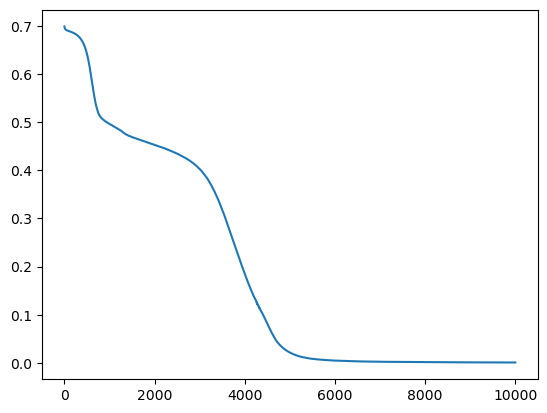

In [8]:
model.train()
for epoch in tqdm(range(10000)):
    for i in range(len(train_dataset)):
        optimizer.zero_grad()
        y_pred = model(train_dataset[i]['window'])
        # print(y_pred)

        # if epoch == 0:
        #     print(y_pred)

        loss = criterion(y_pred, train_dataset[i]['labels'])
        lossi.append(loss.item())

        loss.backward()
        optimizer.step()
        
        # if epoch <= 1:
        #     for p in model.parameters():
        #         print(p.grad)
    
    losses.append(np.mean(lossi))
    lossi = []
    

plt.plot(losses)

print(losses)

print(losses[-1])



In [18]:
model.eval()
truepreds = 0
falsepreds = 0
truepositives = 0
falsepositives = 0
truenegatives = 0
falsenegatives = 0

with torch.no_grad():
    for i in range(len(val_dataset)):
        if i < 3:
            print(val_dataset[i]['window'])
        y_pred = model(val_dataset[i]['window'])
        # print(y_pred, val_dataset[i]['labels'])
        pred = (y_pred >= 0.5)
        if pred == val_dataset[i]['labels']:
            truepreds += 1
            if pred == 1:
                truepositives += 1
            else:
                truenegatives += 1
        else:
            falsepreds += 1
            if pred == 1:
                falsepositives += 1
            else:
                falsenegatives += 1

print(truepreds / (truepreds + falsepreds))
print(truepositives, truenegatives, falsepositives, falsenegatives)

f1Score = 2 * truepositives / (2 * truepositives + falsepositives + falsenegatives)
print(f1Score)
        

tensor([[0.6284, 0.6588, 0.5611,  ..., 0.3708, 0.5175, 0.2676]])
tensor([[0.8858, 0.4621, 0.8061,  ..., 0.3864, 0.3254, 0.4396]])
tensor([[0.2056, 0.6006, 0.1051,  ..., 0.6421, 0.0988, 0.6036]])
0.8095238095238095
7 10 2 2
0.7777777777777778


In [10]:
print((eeg_dataset[0]['window']))
#print(torch.min((no_normalize[0]['window'] - torch.min(no_normalize[0]['window']))/(torch.max(no_normalize[0]['window']))))

tensor([[0.7548, 0.5327, 0.8003,  ..., 0.4127, 0.7042, 0.4506]])
